In [1]:
!pip install split-folders

In [2]:
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os
import zipfile
import pathlib
import splitfolders

In [3]:
zip_ref = zipfile.ZipFile("/content/citra-uang.zip")
zip_ref.extractall()
zip_ref.close()

In [5]:
!ls /content/Citra Uang Rupiah Emisi 2022

ls: cannot access '/content/Citra': No such file or directory
ls: cannot access 'Uang': No such file or directory
ls: cannot access 'Rupiah': No such file or directory
ls: cannot access 'Emisi': No such file or directory
ls: cannot access '2022': No such file or directory


In [6]:
!mv /content/Citra Uang Rupiah Emisi 2022 /content/citra-uang

mv: target '/content/citra-uang' is not a directory


In [9]:
for dirpath, dirname, filename in os.walk("CitraUangRupiahEmisi2022"):
  print(f"There are {len(dirname)} and {len(filename)} in {dirpath} directory")

There are 7 and 0 in CitraUangRupiahEmisi2022 directory
There are 0 and 200 in CitraUangRupiahEmisi2022/10k directory
There are 0 and 200 in CitraUangRupiahEmisi2022/1k directory
There are 0 and 200 in CitraUangRupiahEmisi2022/50k directory
There are 0 and 200 in CitraUangRupiahEmisi2022/5k directory
There are 0 and 200 in CitraUangRupiahEmisi2022/20k directory
There are 0 and 200 in CitraUangRupiahEmisi2022/2k directory
There are 0 and 200 in CitraUangRupiahEmisi2022/100k directory


In [10]:
path = pathlib.Path("CitraUangRupiahEmisi2022")
class_names = np.array(sorted([item.name for item in path.glob("*")]))
class_names

array(['100k', '10k', '1k', '20k', '2k', '50k', '5k'], dtype='<U4')

In [11]:
splitfolders.ratio(input="CitraUangRupiahEmisi2022",
                   output="dataset_split",
                   seed=42,
                   ratio=(0.7, 0.3))

Copying files: 1400 files [00:01, 1166.21 files/s]


In [32]:
tf.random.set_seed(42)

train_dir = "/content/dataset_split/train"
val_dir = "/content/dataset_split/val"

train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1/255.,
                                                                width_shift_range=0.2,
                                                                height_shift_range=0.2,
                                                                rotation_range=0.3,
                                                                zoom_range=0.2,
                                                                shear_range=0.2,
                                                                brightness_range=(0.2, 0.8),
                                                                horizontal_flip=True)

val_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1/255.)

train_data = train_datagen.flow_from_directory(train_dir,
                                               target_size=(224, 224),
                                               class_mode="categorical",
                                               batch_size=32)

val_data = val_datagen.flow_from_directory(val_dir,
                                           target_size=(224, 224),
                                           class_mode="categorical",
                                           batch_size=32)

Found 980 images belonging to 7 classes.
Found 420 images belonging to 7 classes.


In [33]:
class LrHistory(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        logs['lr'] = tf.keras.backend.get_value(self.model.optimizer.learning_rate)

lr_hist = LrHistory()

In [34]:
def early_stopping():
  return tf.keras.callbacks.EarlyStopping(monitor="val_loss",
                                          restore_best_weights=True,
                                          patience=20)

In [35]:
from tensorflow.keras.callbacks import ReduceLROnPlateau

def reduce_lr():
  return ReduceLROnPlateau(
    monitor='val_loss',   # metrik yang dipantau
    factor=0.5,           # turunkan lr jadi 50% (misal 0.001 -> 0.0005)
    patience=3,           # jika 3 epoch berturut-turut val_loss tidak membaik
    min_lr=1e-6,          # lr minimum
    verbose=1
  )

In [36]:
tf.random.set_seed(42)

model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, 3, activation="relu", input_shape=(224, 224, 3)),
    tf.keras.layers.Conv2D(32, 3, activation="relu"),
    tf.keras.layers.MaxPool2D(),

    tf.keras.layers.Conv2D(64, 3, activation="relu"),
    tf.keras.layers.Conv2D(64, 3, activation="relu"),
    tf.keras.layers.MaxPool2D(),

    tf.keras.layers.Conv2D(128, 3, activation="relu"),
    tf.keras.layers.Conv2D(128, 3, activation="relu"),
    tf.keras.layers.MaxPool2D(),

    tf.keras.layers.Conv2D(256, 3, activation="relu"),
    tf.keras.layers.Conv2D(256, 3, activation="relu"),
    tf.keras.layers.MaxPool2D(),

    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dense(128, activation="relu"),
    tf.keras.layers.Dense(len(class_names), activation="softmax")
])

model.compile(loss="categorical_crossentropy",
              optimizer=tf.keras.optimizers.Adam(),
              metrics=["accuracy"])

history_model = model.fit(train_data,
                          epochs=20,
                          validation_data=val_data,
                          validation_steps=len(val_data),
                          callbacks=[lr_hist, early_stopping(), reduce_lr()])

/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 60s 2s/step - accuracy: 0.1610 - loss: 1.9448 - val_accuracy: 0.1476 - val_loss: 2.4767 - lr: 0.0010 - learning_rate: 0.0010
Epoch 2/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 52s 2s/step - accuracy: 0.2392 - loss: 1.8156 - val_accuracy: 0.3310 - val_loss: 1.6249 - lr: 0.0010 - learning_rate: 0.0010
Epoch 3/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 52s 2s/step - accuracy: 0.3170 - loss: 1.5807 - val_accuracy: 0.3476 - val_loss: 1.5702 - lr: 0.0010 - learning_rate: 0.0010
Epoch 4/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 49s 2s/step - accuracy: 0.3464 - loss: 1.5577 - val_accuracy: 0.3262 - val_loss: 1.5565 - lr: 0.0010 - learning_rate: 0.0010
Epoch 5/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 48s 2s/step - accuracy: 0.3006 - loss: 1.6217 - val_accuracy: 0.3548 - val_loss: 1.6044 - lr: 0.0010 - learning_rate: 0.0010
Epoch 6/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 51s 2s/step - accuracy: 0.3864 - loss: 1.4504 - val_accuracy: 0.4024 - val_loss: 1.3996 - lr: 0.0010 - learning_rate: 0.0010
Epoch 7/20
31/31 ━━━━━

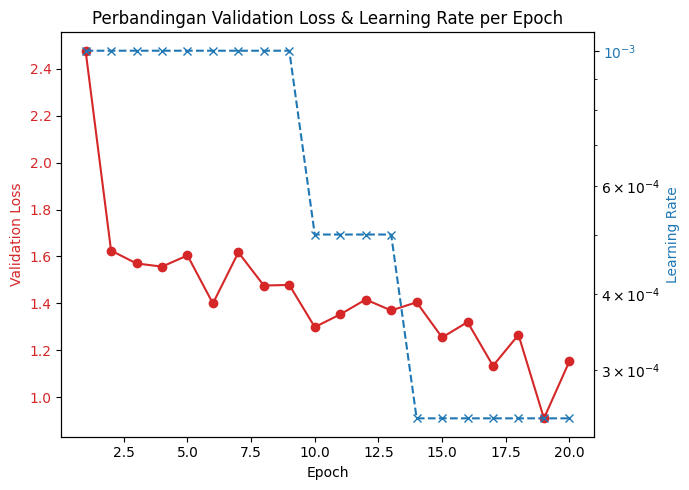

In [37]:
import matplotlib.pyplot as plt
import numpy as np

# ambil data dari history
epochs   = np.arange(len(history_model.history['val_loss'])) + 1
val_loss = history_model.history['val_loss']
lrs      = history_model.history['lr']

fig, ax1 = plt.subplots(figsize=(7,5))

# --- Plot Val Loss (sumbu kiri)
color = 'tab:red'
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Validation Loss', color=color)
ax1.plot(epochs, val_loss, color=color, marker='o', label='Val Loss')
ax1.tick_params(axis='y', labelcolor=color)

# --- Plot Learning Rate (sumbu kanan)
ax2 = ax1.twinx()  # buat sumbu Y kedua
color = 'tab:blue'
ax2.set_ylabel('Learning Rate', color=color)
ax2.plot(epochs, lrs, color=color, marker='x', linestyle='--', label='Learning Rate')
ax2.tick_params(axis='y', labelcolor=color)
ax2.set_yscale('log')  # opsional: log scale biar lebih informatif

plt.title("Perbandingan Validation Loss & Learning Rate per Epoch")
plt.tight_layout()
plt.show()


In [41]:
model.evaluate(val_data)

14/14 ━━━━━━━━━━━━━━━━━━━━ 12s 833ms/step - accuracy: 0.6459 - loss: 0.9710


[0.9100590348243713, 0.6666666865348816]

In [42]:
model.save("model_rupiah.keras")

In [38]:
# Create a function to import an image and resize it to be able to be used with our model
def load_and_prep_image(filename, img_shape=224):
  '''
  Reads and image from filename, turns it
  into a tensor and reshapes it to (img_shape, img_shape, colour_channels).
  '''
  # Read in the image
  img = tf.io.read_file(filename)
  # Decode the read file into a tensor
  img = tf.image.decode_image(img)
  # Resize the image
  img = tf.image.resize(img, size=[img_shape, img_shape])
  # Rescale the image
  img = img/255.
  # Return the tensor
  return img

In [39]:
def pred_and_plot(model, filename, class_names=class_names):
  '''
  Imports an image located at filename, makes a prediction with model
  and plots the image with the predicted class as the title
  '''
  # Import the target image and preprocess it
  img = load_and_prep_image(filename)
  pred = model.predict(tf.expand_dims(img, axis=0))
  pred_class_index = tf.argmax(pred[0])
  class_pred = class_names[pred_class_index]

  plt.imshow(img)
  plt.title(f"Prediction : {class_pred} with conviction : {tf.reduce_max(pred)*100:.2f}")
  plt.axis(False)
  plt.grid(False)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 493ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


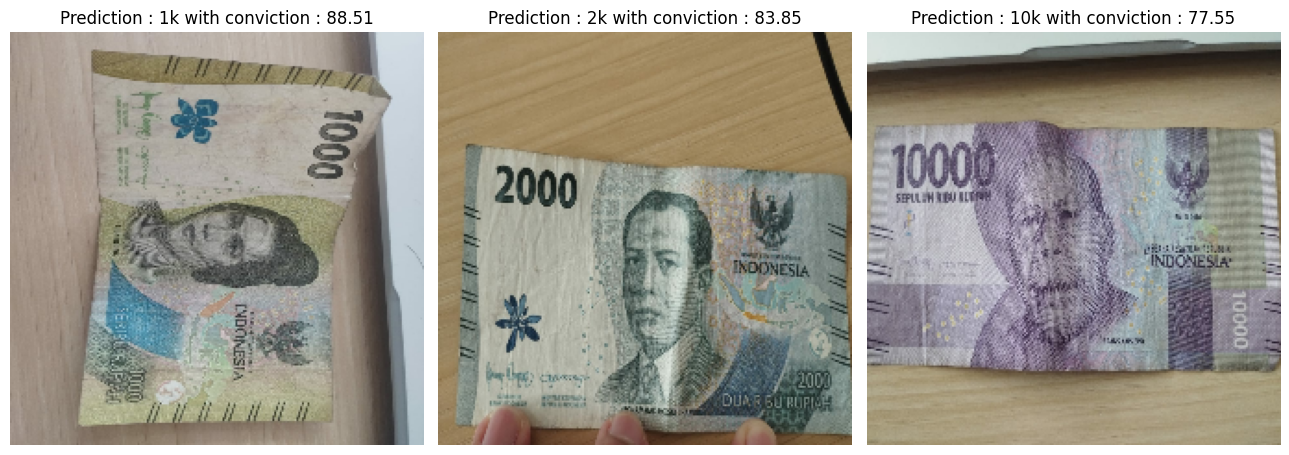

In [40]:
list_img = ["/content/seribu.jpeg", "/content/duaribu.jpeg", "/content/sepuluhribu.jpeg"]

plt.figure(figsize=(13, 10))

for i, img in enumerate(list_img):
  plt.subplot(1, 3, i+1)
  pred_and_plot(model=model, filename=img, class_names=class_names)

plt.tight_layout()